## Pyspark Dataframe

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark=(SparkSession.builder.appName('SparkSQL').getOrCreate())

In [5]:
tweet = (spark.read.format('csv')
         .option('inferSchema', 'true')
         .option('header', 'false')
         .load('file:///home/hduser/Downloads/ProjectTweets.csv')
         .toDF('ID', 'ID1', 'Date', 'Flag', 'User', 'Text'))

In [6]:
tweet.show()

+---+----------+--------------------+--------+---------------+--------------------+
| ID|       ID1|                Date|    Flag|           User|                Text|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [7]:
tweet.createOrReplaceTempView('Tweets')

In [8]:
spark.sql('SELECT Date, Text FROM Tweets').show(5)

+--------------------+--------------------+
|                Date|                Text|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|@switchfoot http:...|
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
+--------------------+--------------------+
only showing top 5 rows



In [9]:
tweet.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- ID1: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Text: string (nullable = true)



In [10]:
from pyspark.sql.functions import lower

tweet = tweet.withColumn("Text", lower(tweet["Text"]))


In [11]:
#pip install --upgrade numpy==1.24.3 

In [12]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol='Text', outputCol='Text1')
tweet = tokenizer.transform(tweet)

In [13]:
from pyspark.ml.feature import StopWordsRemover

remover= StopWordsRemover(inputCol='Text1', outputCol='Text2')
tweet = remover.transform(tweet)

In [14]:
tweet.select("Text", "Text1", 'Text2').show()

+--------------------+--------------------+--------------------+
|                Text|               Text1|               Text2|
+--------------------+--------------------+--------------------+
|@switchfoot http:...|[@switchfoot, htt...|[@switchfoot, htt...|
|is upset that he ...|[is, upset, that,...|[upset, update, f...|
|@kenichan i dived...|[@kenichan, i, di...|[@kenichan, dived...|
|my whole body fee...|[my, whole, body,...|[whole, body, fee...|
|@nationwideclass ...|[@nationwideclass...|[@nationwideclass...|
|@kwesidei not the...|[@kwesidei, not, ...|[@kwesidei, whole...|
|         need a hug |      [need, a, hug]|         [need, hug]|
|@loltrish hey  lo...|[@loltrish, hey, ...|[@loltrish, hey, ...|
|@tatiana_k nope t...|[@tatiana_k, nope...|  [@tatiana_k, nope]|
|@twittera que me ...|[@twittera, que, ...|[@twittera, que, ...|
|spring break in p...|[spring, break, i...|[spring, break, p...|
|i just re-pierced...|[i, just, re-pier...|  [re-pierced, ears]|
|@caregiving i cou...|[@c

In [15]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

def get_sentiment(text):
    text_str = str(text)
    analysis = TextBlob(text_str)
    return analysis.sentiment.polarity

sentiment_udf = udf(get_sentiment, FloatType())
tweet = tweet.withColumn('Sentiment', sentiment_udf('Text1'))

tweet.select('Text1', 'Sentiment').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|Text1                                                                                                                                        |Sentiment  |
+---------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[@switchfoot, http://twitpic.com/2y1zl, -, awww,, that's, a, bummer., , you, shoulda, got, david, carr, of, third, day, to, do, it., ;d]     |0.2        |
|[is, upset, that, he, can't, update, his, facebook, by, texting, it..., and, might, cry, as, a, result, , school, today, also., blah!]       |0.0        |
|[@kenichan, i, dived, many, times, for, the, ball., managed, to, save, 50%, , the, rest, go, out, of, bounds]                                |0.5        |
|[my, whole, body, feels, itchy, and, like, its, on, fire]      

In [16]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import StringType

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if isinstance(text, list):
        text = ' '.join(map(str, text))
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] > 0.3:
        return 'Positive'
    elif sentiment['compound'] < -0.3:
        return 'Negative'
    else:
        return 'Neutral'
    
sentiment_udf = udf(analyze_sentiment, StringType())

tweet = tweet.withColumn('Polarity', sentiment_udf('Text2'))

tweet.select('Sentiment', 'Polarity').show(truncate=False)

+-----------+--------+
|Sentiment  |Polarity|
+-----------+--------+
|0.2        |Neutral |
|0.0        |Negative|
|0.5        |Positive|
|0.2        |Neutral |
|-0.625     |Negative|
|0.2        |Neutral |
|0.0        |Positive|
|0.27083334 |Positive|
|0.0        |Neutral |
|0.0        |Neutral |
|-0.21428572|Neutral |
|0.0        |Neutral |
|0.0        |Negative|
|0.0        |Neutral |
|0.075      |Negative|
|0.0        |Positive|
|0.0        |Negative|
|0.0        |Neutral |
|0.78125    |Positive|
|0.0        |Neutral |
+-----------+--------+
only showing top 20 rows



In [18]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="Text2", 
                     outputCol="Features", 
                     vocabSize=3, 
                     minDF=1.0)

In [19]:
model = cv.fit(tweet)
result = model.transform(tweet)

In [20]:
result.select("Features").show(truncate=False)

+-------------+
|Features     |
+-------------+
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[0],[2.0])|
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[],[])    |
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[0],[3.0])|
|(3,[0],[1.0])|
|(3,[0],[1.0])|
|(3,[],[])    |
|(3,[0],[1.0])|
|(3,[],[])    |
+-------------+
only showing top 20 rows



In [21]:
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

label_indexer = StringIndexer(inputCol="User", outputCol="Label_Index").fit(tweet)
df = label_indexer.transform(tweet)

In [22]:
hashingTF = HashingTF(inputCol="Text2", outputCol="Raw_Features", numFeatures=20)
idf = IDF(inputCol="Raw_Features", outputCol="features")
pipeline = Pipeline(stages=[hashingTF, idf])

In [23]:
model = pipeline.fit(df)
df = model.transform(df)

In [24]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=1234)

In [25]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [26]:
nb = NaiveBayes(featuresCol="features", 
                labelCol="Label_Index", 
                predictionCol="prediction", 
                smoothing=1.0, 
                modelType="multinomial")
nb_model = nb.fit(trainingData)

2023-11-16 10:26:13,932 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.6 MiB
2023-11-16 10:33:43,470 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 20.5 MiB


In [27]:
spark = SparkSession.builder.config("spark.network.timeout", "600s").getOrCreate()

In [28]:
predictions = nb_model.transform(testData)

In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label_Index", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = {:.2f}%".format(accuracy * 100))

2023-11-16 10:44:38,184 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 116.9 MiB
2023-11-16 10:46:11,067 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:12,169 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:13,741 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:14,416 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:15,002 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:15,597 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:15,597 WARN memory.TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
2023-11-16 10:46:16,184 WARN memory.TaskMemoryManager: Failed to allocate a page (2700083 bytes), try again.
2023-11-16 10:46:17,540 

Py4JJavaError: An error occurred while calling o444.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 20.0 failed 1 times, most recent failure: Lost task 0.0 in stage 20.0 (TID 25) (10.0.2.15 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (HashingTF$$Lambda$3820/923410012: (array<string>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2450)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2399)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2398)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2398)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1156)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2638)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2580)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2569)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2224)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2245)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2264)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2289)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:737)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:736)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy$lzycompute(MulticlassMetrics.scala:188)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.accuracy(MulticlassMetrics.scala:188)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:154)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (HashingTF$$Lambda$3820/923410012: (array<string>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:136)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1491)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 47584)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pyspark/serializers.py",

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label_Index", 
    predictionCol="prediction",  
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print("Test set accuracy = {:.2f}%".format(accuracy * 100))

ConnectionRefusedError: [Errno 111] Connection refused

## MongoDB

In [42]:
#pip install pymongo_spark

In [43]:
#pip install pyspark

In [1]:
df = spark.read \
    .format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/twitter.tweet") \
    .load()

Py4JJavaError: An error occurred while calling o34.load.
: java.lang.ClassNotFoundException: 
Failed to find data source: com.mongodb.spark.sql.DefaultSource. Please find packages at
http://spark.apache.org/third-party-projects.html
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedToFindDataSourceError(QueryExecutionErrors.scala:443)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:670)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSourceV2(DataSource.scala:720)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:210)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:174)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.ClassNotFoundException: com.mongodb.spark.sql.DefaultSource.DefaultSource
	at java.net.URLClassLoader.findClass(URLClassLoader.java:387)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:418)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:351)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$5(DataSource.scala:656)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$lookupDataSource$4(DataSource.scala:656)
	at scala.util.Failure.orElse(Try.scala:224)
	at org.apache.spark.sql.execution.datasources.DataSource$.lookupDataSource(DataSource.scala:656)
	... 15 more


In [50]:
import pymongo

In [51]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter"]
collection = db["tweet"]

In [52]:
tweet_panda = tweet.toPandas()

2023-11-15 20:26:01,259 ERROR executor.Executor: Exception in task 1.0 in stage 16.0 (TID 21)
java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:44)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializ

Py4JJavaError: An error occurred while calling o125.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 16.0 failed 1 times, most recent failure: Lost task 1.0 in stage 16.0 (TID 21) (10.0.2.15 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:44)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:101)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2450)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2399)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2398)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2398)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1156)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1156)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2638)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2580)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2569)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2224)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2245)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2264)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2289)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:410)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3538)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3535)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at org.apache.spark.util.ByteBufferOutputStream.write(ByteBufferOutputStream.scala:41)
	at java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1877)
	at java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1786)
	at java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1189)
	at java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:348)
	at org.apache.spark.serializer.JavaSerializationStream.writeObject(JavaSerializer.scala:44)
	at org.apache.spark.serializer.JavaSerializerInstance.serialize(JavaSerializer.scala:101)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51496)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 235, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 239, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pyspark/serializers.py",

In [1]:
#df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [53]:
#pip install pandas pymongo

In [54]:
import pandas as pd
from pymongo import MongoClient

mongo_uri = "mongodb://localhost:27017/"
database_name = "twitter"
collection_name = "tweet"

client = MongoClient(mongo_uri)
db = client[database_name]
collection = db[collection_name]

cursor = collection.find()
tweet = pd.DataFrame(list(cursor))

ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 655529abf8f0252446f8ebe3, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

## Panda Dataframe

In [1]:
import pandas as pd

In [2]:
tweet = pd.read_csv('ProjectTweets.csv')

In [3]:
tweet.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
tweet.tail()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1599994,1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


## Cleaning and preparing 

In [5]:
tweet.columns = ['ID', 'ID1', 'Date', 'Flag', 'User', 'Text']

In [6]:
tweet.head()

,ID,ID1,Date,Flag,User,Text
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
tweet.dtypes

ID       int64
ID1      int64
Date    object
Flag    object
User    object
Text    object
dtype: object

In [8]:
print(tweet.isnull().sum())

ID      0
ID1     0
Date    0
Flag    0
User    0
Text    0
dtype: int64


In [9]:
#pip install skforecast

In [10]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [11]:
tweet['Flag'].unique()

array(['NO_QUERY'], dtype=object)

In [12]:
tweet.drop(['ID', 'Flag'], axis=1, inplace=True)

In [13]:
tweet['Date']=tweet['Date'].str.replace('PDT', '', regex=False)

In [14]:
tweet.head()

,ID1,Date,User,Text
0,1467810672,Mon Apr 06 22:19:49 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 2009,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 2009,joy_wolf,@Kwesidei not the whole crew


In [15]:
tweet['Date']=pd.to_datetime(pd.Series(tweet['Date']))
tweet['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

0          2009-04-06 22:19:49
1          2009-04-06 22:19:53
2          2009-04-06 22:19:57
3          2009-04-06 22:19:57
4          2009-04-06 22:20:00
                  ...         
1599994    2009-06-16 08:40:49
1599995    2009-06-16 08:40:49
1599996    2009-06-16 08:40:49
1599997    2009-06-16 08:40:49
1599998    2009-06-16 08:40:50
Name: Date, Length: 1599999, dtype: object

In [16]:
tweet.head()

,ID1,Date,User,Text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


## Sentiment Analysis

In [17]:
#pip install nltk

In [18]:
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def get_text_processing(Text):
    stpword=stopwords.words('english')
    no_punctuation=[char for char in Text if char not in string.punctuation]
    no_punctuation=''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [20]:
tweet['Review']=tweet['Text'].apply(get_text_processing)

In [21]:
#pip install textblob

In [22]:
from textblob import TextBlob

In [23]:
def get_sentiment(Text):
    analysis=TextBlob(Text)
    return analysis.sentiment.polarity

In [24]:
tweet['Sentiment']=tweet['Review'].apply(get_sentiment)

In [25]:
tweet.head()

,ID1,Date,User,Text,Review,Sentiment
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update Facebook texting might cry r...,0.000
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan dived many times ball Managed save 50...,0.500
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire,0.200
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see,-0.625
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew,Kwesidei whole crew,0.200


In [26]:
tweet.drop(['ID1', 'User', 'Text'], axis=1, inplace=True)

In [27]:
tweet['Rating'] = tweet['Sentiment'].apply(lambda x:'Positive' if x>0.3 
                                           else ('Negavtive'if x<-0.3 else 'Neutral'))

In [28]:
tweet.head()

,Date,Review,Sentiment,Rating
0,2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
1,2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2,2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
3,2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
4,2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [29]:
import seaborn as sns

/tmp/ipykernel_2929/3720026483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=tweet, palette='summer')


<AxesSubplot:xlabel='Rating', ylabel='count'>

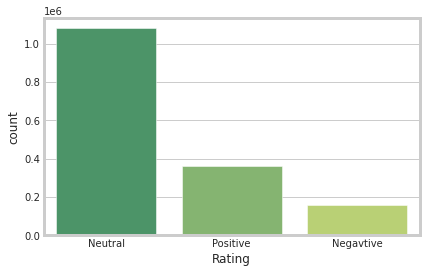

In [30]:
sns.set_style('whitegrid')
sns.countplot(x='Rating', data=tweet, palette='summer')

In [31]:
tweet = tweet.set_index('Date')

In [32]:
tweet.head()

,Review,Sentiment,Rating
Date,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,0.000,Neutral
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,0.500,Positive
2009-04-06 22:19:57,whole body feels itchy like fire,0.200,Neutral
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,-0.625,Negavtive
2009-04-06 22:20:00,Kwesidei whole crew,0.200,Neutral


In [33]:
time = tweet[['Sentiment']].copy()

In [34]:
tweet.drop(['Sentiment'], axis=1, inplace=True)

In [35]:
one_hot = pd.get_dummies(tweet["Rating"])
tweet.drop(['Rating'],axis=1,inplace=True)
tweet = pd.concat([tweet,one_hot],axis=1)
tweet.head()

,Review,Negavtive,Neutral,Positive
Date,,,,
2009-04-06 22:19:49,upset cant update Facebook texting might cry r...,False,True,False
2009-04-06 22:19:53,Kenichan dived many times ball Managed save 50...,False,False,True
2009-04-06 22:19:57,whole body feels itchy like fire,False,True,False
2009-04-06 22:19:57,nationwideclass behaving im mad cant see,True,False,False
2009-04-06 22:20:00,Kwesidei whole crew,False,True,False


In [36]:
tweet.reset_index(drop=True, inplace=True)

In [37]:
tweet['Negavtive'] = tweet['Negavtive'].astype(int)
tweet['Neutral'] = tweet['Neutral'].astype(int)
tweet['Positive'] = tweet['Positive'].astype(int)

In [38]:
tweet.shape

(1599999, 4)

In [39]:
tweet.head()

,Review,Negavtive,Neutral,Positive
0,upset cant update Facebook texting might cry r...,0,1,0
1,Kenichan dived many times ball Managed save 50...,0,0,1
2,whole body feels itchy like fire,0,1,0
3,nationwideclass behaving im mad cant see,1,0,0
4,Kwesidei whole crew,0,1,0


In [40]:
from sklearn.model_selection import train_test_split
X = tweet['Review'].values
y = tweet.drop('Review', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [41]:
X_train

array(['kaseey im process cutting stuff wall collage haha youre done wanna see picture',
       'Already work hour woe', 'Writing essay college writing boring',
       ...,
       'SarahFTW know sometimes pretend superpower like say something true would awesome power',
       'Cant believe came asked', 'back bali'], dtype=object)

In [42]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [66]:
#dont implement!!!!!!!
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 10000 
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences)
X_test_padded = pad_sequences(X_test_sequences, 
                              maxlen=X_train_padded.shape[1])

#encoder = OneHotEncoder(sparse=False)
#y_train_encoded = encoder.fit_transform(y_train)
#y_test_encoded = encoder.transform(y_test)

model = Sequential()
model.add(Embedding(input_dim=max_words, 
                    output_dim=32, 
                    input_length=X_train_padded.shape[1]))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax')) 

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, 
          epochs=10, batch_size=256, 
          validation_data=(X_test_padded, y_test))

Epoch 1/10
4375/4375 [==============================] - 578s 132ms/step - loss: 0.1222 - accuracy: 0.9578 - val_loss: 0.0608 - val_accuracy: 0.9825
Epoch 2/10
4375/4375 [==============================] - 548s 125ms/step - loss: 0.0504 - accuracy: 0.9861 - val_loss: 0.0472 - val_accuracy: 0.9872
Epoch 3/10
4375/4375 [==============================] - 508s 116ms/step - loss: 0.0389 - accuracy: 0.9898 - val_loss: 0.0399 - val_accuracy: 0.9899
Epoch 4/10
4375/4375 [==============================] - 481s 110ms/step - loss: 0.0328 - accuracy: 0.9917 - val_loss: 0.0389 - val_accuracy: 0.9904
Epoch 5/10
4375/4375 [==============================] - 506s 116ms/step - loss: 0.0283 - accuracy: 0.9929 - val_loss: 0.0388 - val_accuracy: 0.9910
Epoch 6/10
4375/4375 [==============================] - 495s 113ms/step - loss: 0.0247 - accuracy: 0.9938 - val_loss: 0.0423 - val_accuracy: 0.9902
Epoch 7/10
4375/4375 [==============================] - 495s 113ms/step - loss: 0.0215 - accuracy: 0.9945 - val_

In [67]:
model_score = model.evaluate(X_test_padded, y_test, 
                             batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

7500/7500 [==============================] - 114s 15ms/step - loss: 0.0489 - accuracy: 0.9897
Test accuracy: 0.9897395968437195


In [68]:
preds = model.predict(X_test_padded)
preds

15000/15000 [==============================] - 108s 7ms/step


array([[4.62804316e-03, 9.95361805e-01, 1.00503139e-05],
       [6.18710692e-05, 9.99828815e-01, 1.09393906e-04],
       [1.43442258e-10, 1.13301921e-05, 9.99988616e-01],
       ...,
       [2.53839345e-11, 5.98701149e-07, 9.99999344e-01],
       [9.42088187e-01, 5.79117648e-02, 1.37244607e-08],
       [9.82800952e-09, 5.08274941e-04, 9.99491632e-01]], dtype=float32)

In [69]:
preds.shape

(480000, 3)

## Time Series Analysis

In [75]:
time.reset_index(inplace=True)

In [76]:
time = time.set_index('Date')

In [77]:
time.head()

,Sentiment
Date,
2009-04-06 22:19:49,0.000
2009-04-06 22:19:53,0.500
2009-04-06 22:19:57,0.200
2009-04-06 22:19:57,-0.625
2009-04-06 22:20:00,0.200


In [78]:
time.index = pd.to_datetime(time.index)
dtime = time.resample('D').mean().reset_index()

In [79]:
diftime=dtime.copy()

In [80]:
dtime

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN
...,...,...
76,2009-06-21,0.003373
77,2009-06-22,-0.024647
78,2009-06-23,-0.016030
79,2009-06-24,-0.014245


In [81]:
print(dtime.isnull().sum())

Date          0
Sentiment    33
dtype: int64


In [82]:
time_linear_interpolation = dtime.interpolate(method='linear')

In [83]:
dtime.interpolate(method='linear', inplace=True)

In [84]:
dtime

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,0.101622
3,2009-04-09,0.103854
4,2009-04-10,0.106085
...,...,...
76,2009-06-21,0.003373
77,2009-06-22,-0.024647
78,2009-06-23,-0.016030
79,2009-06-24,-0.014245


In [85]:
print(dtime.isnull().sum())

Date         0
Sentiment    0
dtype: int64


In [86]:
dtime = dtime.set_index('Date')

In [87]:
(dtime.index == pd.date_range(start=dtime.index.min(),
                             end=dtime.index.max(),
                             freq=dtime.index.freq)).all()

True

Train dates : 2009-04-06 00:00:00 --- 2009-06-10 00:00:00  (n=66)
Test dates  : 2009-06-11 00:00:00 --- 2009-06-25 00:00:00  (n=15)


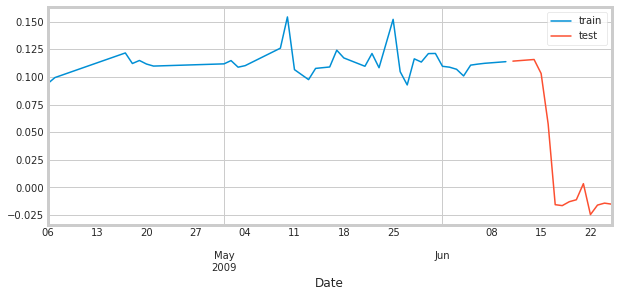

In [88]:
steps = 15
dtime_train = dtime[:-steps]
dtime_test  = dtime[-steps:]

print(f"Train dates : {dtime_train.index.min()} --- {dtime_train.index.max()}  (n={len(dtime_train)})")
print(f"Test dates  : {dtime_test.index.min()} --- {dtime_test.index.max()}  (n={len(dtime_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train')
dtime_test['Sentiment'].plot(ax=ax, label='test')
ax.legend();

In [89]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=dtime_train['Sentiment'])
forecaster

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 65] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-11-17 21:25:38 
Last fit date: 2023-11-17 21:25:38 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [90]:
steps = 15
predictions = forecaster.predict(steps=steps)
predictions.head(5)

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


6     0.115862
7     0.117686
8     0.119138
9     0.119190
10    0.115782
Name: pred, dtype: float64

In [91]:
print(dtime_train.index)
print(dtime_test.index)
print(predictions.index)

DatetimeIndex(['2009-04-06', '2009-04-07', '2009-04-08', '2009-04-09',
               '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13',
               '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17',
               '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21',
               '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-25',
               '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',
               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',
               '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11',
               '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15',
               '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23',
               '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27',
               '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31',
      

In [92]:
dtime_train.index = pd.to_datetime(dtime_train.index)
dtime_test.index = pd.to_datetime(dtime_test.index)
predictions.index = pd.to_datetime(predictions.index)

In [93]:
predictions

1970-01-01 00:00:00.000000006    0.115862
1970-01-01 00:00:00.000000007    0.117686
1970-01-01 00:00:00.000000008    0.119138
1970-01-01 00:00:00.000000009    0.119190
1970-01-01 00:00:00.000000010    0.115782
1970-01-01 00:00:00.000000011    0.114500
1970-01-01 00:00:00.000000012    0.114162
1970-01-01 00:00:00.000000013    0.112821
1970-01-01 00:00:00.000000014    0.113877
1970-01-01 00:00:00.000000015    0.113683
1970-01-01 00:00:00.000000016    0.115776
1970-01-01 00:00:00.000000017    0.118226
1970-01-01 00:00:00.000000018    0.119280
1970-01-01 00:00:00.000000019    0.119661
1970-01-01 00:00:00.000000020    0.115901
Name: pred, dtype: float64

In [94]:
predictions.reset_index(drop=True, inplace=True)  
predictions.index = pd.date_range(start='2009-06-11', periods=len(predictions))  

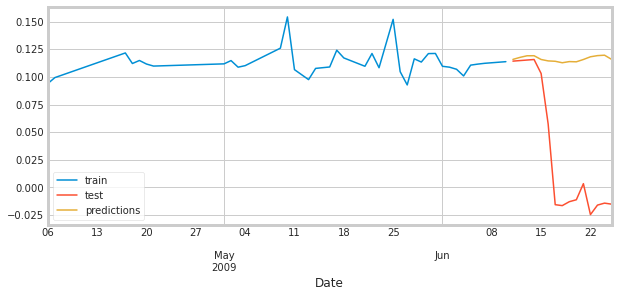

In [95]:
fig, ax = plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train', x=dtime_train.index.tolist())
dtime_test['Sentiment'].plot(ax=ax, label='test', x=dtime_test.index.tolist())
predictions.plot(ax=ax, label='predictions', x=predictions.index.tolist())
ax.legend();

In [96]:
error_mse = mean_squared_error(
                y_true = dtime_test['Sentiment'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.010346302226309632


In [97]:
dtime.shape

(81, 1)

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

data = {'Date': pd.date_range(start='2009-04-06', periods=81, freq='D'),
        'Sentiment': dtime['Sentiment']}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

X = df.index.values.reshape(-1, 1)
y = df['Sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

val_mse = -grid_search.best_score_
print("Validation Mean Squared Error:", val_mse)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Validation Mean Squared Error: 0.00016582839391255812


In [99]:
regressor = RandomForestRegressor(max_depth=20, n_estimators=200, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=dtime_train['Sentiment'])

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [100]:
predictions = forecaster.predict(steps=steps)

/home/hduser/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [101]:
dtime_train.index = pd.to_datetime(dtime_train.index)
dtime_test.index = pd.to_datetime(dtime_test.index)
predictions.index = pd.to_datetime(predictions.index)

In [102]:
predictions

1970-01-01 00:00:00.000000020    0.113092
1970-01-01 00:00:00.000000021    0.111371
1970-01-01 00:00:00.000000022    0.112688
1970-01-01 00:00:00.000000023    0.113233
1970-01-01 00:00:00.000000024    0.113639
1970-01-01 00:00:00.000000025    0.119868
1970-01-01 00:00:00.000000026    0.117469
1970-01-01 00:00:00.000000027    0.116852
1970-01-01 00:00:00.000000028    0.118300
1970-01-01 00:00:00.000000029    0.114039
1970-01-01 00:00:00.000000030    0.111686
1970-01-01 00:00:00.000000031    0.111393
1970-01-01 00:00:00.000000032    0.110356
1970-01-01 00:00:00.000000033    0.110267
1970-01-01 00:00:00.000000034    0.111142
Name: pred, dtype: float64

In [103]:
predictions.reset_index(drop=True, inplace=True)  
predictions.index = pd.date_range(start='2009-06-11', periods=len(predictions)) 

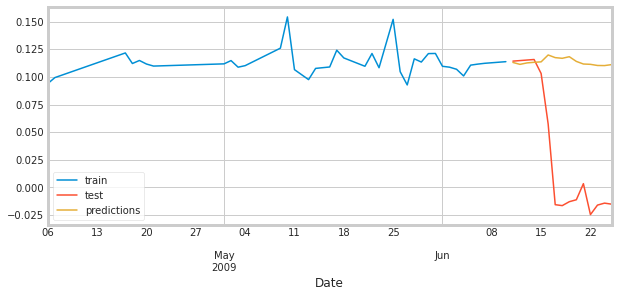

In [104]:
fig, ax = plt.subplots(figsize=(9, 4))
dtime_train['Sentiment'].plot(ax=ax, label='train')
dtime_test['Sentiment'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [105]:
dtime.head()

,Sentiment
Date,
2009-04-06,0.093988
2009-04-07,0.099391
2009-04-08,0.101622
2009-04-09,0.103854
2009-04-10,0.106085


In [106]:
dtime_train.shape

(66, 1)

In [107]:
dtime.tail()

,Sentiment
Date,
2009-06-21,0.003373
2009-06-22,-0.024647
2009-06-23,-0.016030
2009-06-24,-0.014245
2009-06-25,-0.015183


In [108]:
train_size=66

In [109]:
import pandas as pd
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series

data = {'Date': pd.date_range(start='2009-04-06', end='2009-06-25', freq='D'),
        'Sentiment': dtime['Sentiment']}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

dtime_train, dtime_test = df.iloc[:train_size], df.iloc[train_size:]

order = (1, 1, 1)
model = ARIMA(order=order)
model.fit(dtime_train['Sentiment'])

steps = len(dtime_test)
fh = pd.date_range(start=dtime_test.index[0], periods=steps, freq='D')

y_pred = model.predict(fh)

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [110]:
y_pred

2009-06-11    0.114962
2009-06-12    0.115424
2009-06-13    0.115642
2009-06-14    0.115775
2009-06-15    0.115877
2009-06-16    0.115969
2009-06-17    0.116056
2009-06-18    0.116143
2009-06-19    0.116229
2009-06-20    0.116315
2009-06-21    0.116401
2009-06-22    0.116486
2009-06-23    0.116572
2009-06-24    0.116658
2009-06-25    0.116744
Freq: D, Name: Sentiment, dtype: float64

In [124]:
dtime_test

,Sentiment
Date,
2009-06-11,0.114296
2009-06-12,0.114787
2009-06-13,0.115279
2009-06-14,0.115770
2009-06-15,0.103107
2009-06-16,0.057334
2009-06-17,-0.015653
2009-06-18,-0.016503
2009-06-19,-0.012951


In [115]:
steps = 7
fh7 = pd.date_range(start='2009-06-26', periods=steps, freq='D')

y_7 = model.predict(fh7)

In [116]:
y_7

2009-06-26    0.116830
2009-06-27    0.116915
2009-06-28    0.117001
2009-06-29    0.117087
2009-06-30    0.117173
2009-07-01    0.117259
2009-07-02    0.117344
Freq: D, Name: Sentiment, dtype: float64

In [117]:
steps = 30
fh30 = pd.date_range(start='2009-06-26', periods=steps, freq='D')

y_30 = model.predict(fh30)

In [118]:
y_30

2009-06-26    0.116830
2009-06-27    0.116915
2009-06-28    0.117001
2009-06-29    0.117087
2009-06-30    0.117173
2009-07-01    0.117259
2009-07-02    0.117344
2009-07-03    0.117430
2009-07-04    0.117516
2009-07-05    0.117602
2009-07-06    0.117687
2009-07-07    0.117773
2009-07-08    0.117859
2009-07-09    0.117945
2009-07-10    0.118031
2009-07-11    0.118116
2009-07-12    0.118202
2009-07-13    0.118288
2009-07-14    0.118374
2009-07-15    0.118460
2009-07-16    0.118545
2009-07-17    0.118631
2009-07-18    0.118717
2009-07-19    0.118803
2009-07-20    0.118888
2009-07-21    0.118974
2009-07-22    0.119060
2009-07-23    0.119146
2009-07-24    0.119232
2009-07-25    0.119317
Freq: D, Name: Sentiment, dtype: float64

In [119]:
steps = 90
fh90 = pd.date_range(start='2009-06-26', periods=steps, freq='D')

y_90 = model.predict(fh90)

In [120]:
y_90

2009-06-26    0.116830
2009-06-27    0.116915
2009-06-28    0.117001
2009-06-29    0.117087
2009-06-30    0.117173
                ...   
2009-09-19    0.124121
2009-09-20    0.124207
2009-09-21    0.124293
2009-09-22    0.124379
2009-09-23    0.124464
Freq: D, Name: Sentiment, Length: 90, dtype: float64

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

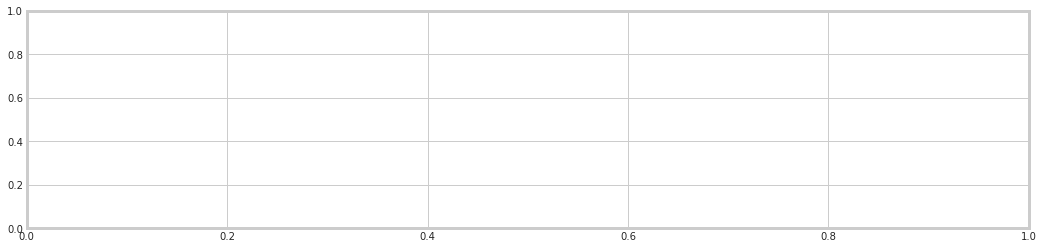

In [94]:
fig, ax = plot_series(df['Sentiment'], labels=['Actual Data'])
ax.plot(dtime_train.index, dtime_train['Sentiment'], label='Training Data', linestyle='--', color='orange')
ax.plot(dtime_test.index, dtime_test['Sentiment'], label='Testing Data', linestyle='--', color='green')
ax.plot(dtime_test.index[:len(y_pred)], y_new['Sentiment'], label='Predictions', linestyle='--', color='red')
ax.legend()
plt.show()

In [76]:
#pip install pmdarima

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(dtime['Sentiment'], model='additive')

In [78]:
trend= result.trend
seasonal=result.seasonal

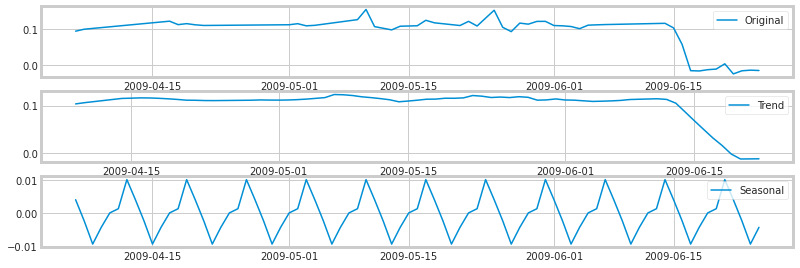

In [79]:
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(dtime['Sentiment'], label='Original')
plt.legend(loc='best')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

### Removing NaN values

In [55]:
diftime.head()

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-08,NaN
3,2009-04-09,NaN
4,2009-04-10,NaN


In [56]:
diftime_cleaned = diftime.dropna()

In [57]:
diftime_cleaned = diftime_cleaned.reset_index(drop=True)

In [58]:
diftime_cleaned.head()

,Date,Sentiment
0,2009-04-06,0.093988
1,2009-04-07,0.099391
2,2009-04-17,0.121702
3,2009-04-18,0.112139
4,2009-04-19,0.114881


In [84]:
#pip install fbprophet

In [86]:
from fbprophet import Prophet
import matplotlib.pyplot as plt

data = {'Date': pd.to_datetime(diftime_cleaned['Date']),
        'Sentiment': diftime_cleaned['Sentiment']}
dotime = pd.DataFrame(data)

dotime.rename(columns={'Date': 'ds', 'Sentiment': 'y'}, inplace=True)

model = Prophet()
model.fit(dotime)

future = model.make_future_dataframe(periods=7)  

forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

ModuleNotFoundError: No module named 'fbprophet'

In [49]:
periods = [7, 30, 90]

In [50]:
result = {'ARIMA':[], 'Exponential Smoothing':[]}

In [65]:
diftime_cleaned.set_index('Date')

,Sentiment
Date,
2009-04-06,0.093988
2009-04-07,0.099391
2009-04-17,0.121702
2009-04-18,0.112139
2009-04-19,0.114881
2009-04-20,0.111665
2009-04-21,0.109819
2009-05-01,0.111823
2009-05-02,0.114778


In [68]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

for period in periods:

    arima_model = ARIMA(dtime['Sentiment'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=period)

    # Exponential Smoothing (Holt-Winters) Forecasting
    exp_model = ExponentialSmoothing(dtime['Sentiment'], 
                                     trend='add', 
                                     seasonal='add', 
                                     seasonal_periods=7)
    exp_fit = exp_model.fit()
    exp_forecast = exp_fit.forecast(steps=period)

    result['ARIMA'].append(arima_forecast)
    result['Exponential Smoothing'].append(exp_forecast)


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

In [125]:
for i, period in enumerate(periods):
    print(f"Forecasts for {period} days:")
    print(f"ARIMA Forecast: {result['ARIMA'][i]}")
    print(f"Exponential Smoothing Forecast: {result['Exponential Smoothing'][i]}")
    print()

Forecasts for 7 days:
ARIMA Forecast: 48   -0.007461
49   -0.014279
50   -0.013663
51   -0.012533
52   -0.014141
53   -0.011530
54   -0.012797
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 48   -0.019486
49   -0.022361
50   -0.012569
51   -0.022711
52   -0.029074
53   -0.034991
54   -0.031784
dtype: float64

Forecasts for 30 days:
ARIMA Forecast: 48   -0.007461
49   -0.014279
50   -0.013663
51   -0.012533
52   -0.014141
53   -0.011530
54   -0.012797
55   -0.013122
56   -0.012504
57   -0.013250
58   -0.012577
59   -0.012693
60   -0.012927
61   -0.012665
62   -0.012908
63   -0.012782
64   -0.012739
65   -0.012843
66   -0.012753
67   -0.012813
68   -0.012804
69   -0.012772
70   -0.012809
71   -0.012784
72   -0.012794
73   -0.012800
74   -0.012786
75   -0.012797
76   -0.012792
77   -0.012792
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 48   -0.019486
49   -0.022361
50   -0.012569
51   -0.022711
52   -0.029074
53   -0.034991
54   -0.031784
55  

Forecasts for 7 days:
ARIMA Forecast: 48   -0.007461
49   -0.014279
50   -0.013663
51   -0.012533
52   -0.014141
53   -0.011530
54   -0.012797
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 48   -0.019486
49   -0.022361
50   -0.012569
51   -0.022711
52   -0.029074
53   -0.034991
54   -0.031784
dtype: float64



ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

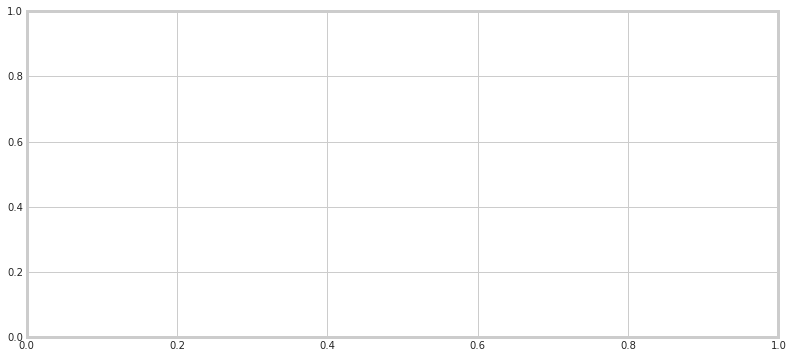

In [70]:
for i, period in enumerate(periods):
    print(f"Forecasts for {period} days:")
    print(f"ARIMA Forecast: {result['ARIMA'][i]}")
    print(f"Exponential Smoothing Forecast: {result['Exponential Smoothing'][i]}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(dtime.index, dtime['Sentiment'], label='Actual Sentiment')
    plt.plot(pd.date_range(start=dtime.index[-1], 
                           periods=period + 1, 
                           closed='right'), 
             result['ARIMA'][i], 
             label='ARIMA Forecast')
    plt.plot(pd.date_range(start=dtime.index[-1], 
                           periods=period + 1, 
                           closed='right'), 
             result['Exponential Smoothing'][i], 
             label='Exponential Smoothing Forecast')
    plt.legend()
    plt.title(f'Sentiment Analysis Forecasting for {period} days')
    plt.show()